Nenwin-project (NEural Networks WIthout Neurons) for
the AI Honors Academy track 2020-2021 at the TU Eindhoven.

Author: Lulof Pirée
March 2021

Copyright (C) 2020 Lulof Pirée, 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Backprob experiment

This file provides a full run of backpropagating though an entire `NenwinModel`.

Author: Lulof Pirée

In [5]:
import torch
import torch.nn as nn
import torchviz

from nenwin.all_particles import Marble, Node, MarbleEaterNode, MarbleEmitterNode
from nenwin.model import NenwinModel
from nenwin.attraction_functions.attraction_functions import NewtonianGravity

## Approach

1. Decide how to capture output and network architecture.
1. Set up the model and the particles.
1. Add a loss function.
1. Visualize the model.
1. Run the model.
1. Backpropagate and update.
1. Compare differences in model.

### Design
Let's create a ring of Nodes, say 5 of them, and put one Marble in there. Not in the center, just somewhere within the circle of space (let's keep it 2D) enclosed by the ring of Nodes.
Now let the loss simply be the distance of the Marble to the center of the circle **after 5 seconds from the start**.

One likely result -- if everything works -- is that the Marble simply is placed stationary on this position. But that would already be some successfull optimization!

In [6]:
zero = torch.tensor([0, 0], dtype=torch.float)
mass = 10

center = torch.tensor([0, 0], dtype=torch.float, requires_grad=False)
node_positions = [torch.tensor(pos, dtype=torch.float) for pos in ((0, 10), (10, 0), (0, -10), (-10, 0))]
marble_pos = torch.tensor([2, 2], dtype=torch.float)

nodes = [Node(pos, zero, zero, mass, NewtonianGravity(), 1, 1, 1, 1) 
    for pos in node_positions]

marble = Marble(marble_pos, zero, zero, mass, NewtonianGravity(), None)

model = NenwinModel(nodes, (marble,))

# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.RMSprop(model.parameters())


torch.autograd.set_detect_anomaly(True)

step_size = 5

for epoch in range(25):
    optimizer.zero_grad(set_to_none=True)

    marble.zero_grad(set_to_none=True)


    model.reset()
    
    
    t = 0
    while t <= 5:
        model.make_timestep(step_size)
        t += step_size

    loss = torch.mean(torch.pow(marble.pos - torch.tensor([0, 0], dtype=torch.float), 2))
    print(f"epoch {epoch}, loss:", loss.item())

    loss.backward(retain_graph=False)
    optimizer.step()


epoch 0, loss: 75.67821502685547
epoch 1, loss: 7075.68359375
epoch 2, loss: 407.37286376953125
epoch 3, loss: 575.3104248046875
epoch 4, loss: 44.499061584472656
epoch 5, loss: 12.239363670349121
epoch 6, loss: 2.234576463699341
epoch 7, loss: 0.8070439100265503
epoch 8, loss: 0.3302481174468994
epoch 9, loss: 0.17212143540382385
epoch 10, loss: 0.0909072756767273
epoch 11, loss: 0.05146942660212517
epoch 12, loss: 0.029325084760785103
epoch 13, loss: 0.017368178814649582
epoch 14, loss: 0.010421965271234512
epoch 15, loss: 0.006448574364185333
epoch 16, loss: 0.004057787358760834
epoch 17, loss: 0.002623380860313773
epoch 18, loss: 0.00172851060051471
epoch 19, loss: 0.0011680437019094825
epoch 20, loss: 0.0008054352947510779
epoch 21, loss: 0.0005689528188668191
epoch 22, loss: 0.00041007850086316466
epoch 23, loss: 0.00030227468232624233
epoch 24, loss: 0.00022752095537725836


In [7]:
marble.pos

tensor([-0.0202,  0.0067], grad_fn=<CloneBackward>)

In [8]:
for node in nodes:
    print(node)

Node(tensor([-0.0880, 10.0888]),tensor([-0.0887,  0.0705]),tensor([-0.0899,  0.0621]),9.953563690185547,NewtonianGravity(),0.83430415391922,0.8788398504257202,0.9637365937232971,0.9045029282569885)
Node(tensor([10.0854, -0.0761]),tensor([ 0.0731, -0.0790]),tensor([ 0.0586, -0.0824]),9.968395233154297,NewtonianGravity(),0.8999937176704407,0.899973452091217,0.9819895625114441,0.8725152015686035)
Node(tensor([ 8.1299e-03, -1.0051e+01]),tensor([-0.0080, -0.0510]),tensor([-0.0349, -0.0472]),10.161704063415527,NewtonianGravity(),0.8879862427711487,0.8107105493545532,1.1657471656799316,0.8995038270950317)
Node(tensor([-10.0183,   0.0135]),tensor([-0.0162,  0.0041]),tensor([-0.0113, -0.0100]),10.182886123657227,NewtonianGravity(),1.000003695487976,0.9989473819732666,1.1838268041610718,1.2057993412017822)


In [9]:
import pickle
with open("marble_to_middle.p", "wb") as file:
    pickle.dump(model, file)

file = open("marble_to_middle.p", "rb")
model = pickle.load(file)
file.close()

In [10]:
from nenwin.architectures.run_and_visualize import run

model.reset()
run(model.marbles, model.nodes)

tensor([])

In [20]:
del run

## Try it with a single Marble -- do the same errors happen?

end epoch 0
0
0
0
end epoch 1
1
0
1
end epoch 2
2
0
2
end epoch 3
3
0
3
end epoch 4
4
0
4
end epoch 5
5
0
5
end epoch 6
6
0
6
end epoch 7
7
0
7
end epoch 8
8
0
8
end epoch 9
9
0
9
end epoch 10
10
0
10
end epoch 11
11
0
11
end epoch 12
12
0
12
end epoch 13
13
0
13
end epoch 14
14
0
14
end epoch 15
15
0
15
end epoch 16
16
0
16
end epoch 17
17
0
17
end epoch 18
18
0
18
end epoch 19
19
0
19
end epoch 20
20
0
20
end epoch 21
21
0
21
end epoch 22
22
0
22
end epoch 23
23
0
23
end epoch 24
24
0
24
prev_prev: 0
prev: 0
init: 25


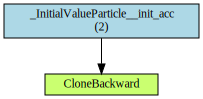

In [5]:
marble = Marble(marble_pos, zero, zero, mass, NewtonianGravity(), None)
optimizer = torch.optim.Adam(marble.parameters())
step_time=0.5


for epoch in range(25):
    optimizer.zero_grad(set_to_none=True)

    marble.zero_grad(set_to_none=True)
    marble.reset()
    # print(vars(marble))
    t = 0
    while t <= 5:
        marble.update_movement(time_passed=step_time)
        t += step_size

    loss = torch.mean(torch.pow(marble.pos - torch.tensor([0, 0], dtype=torch.float), 2))

    print(f"end epoch {epoch}")
    print(marble.init_pos._version)
    print(marble._PhysicalParticle__mass._version)
    print(marble._InitialValueParticle__init_pos._version)

    try:
        loss.backward()
        del loss
        optimizer.step()
    except:
        print("Error occured")
        break
print("prev_prev:", marble._prev_prev_acc._version)
print("prev:", marble._prev_acc._version)
print("init:", marble.init_acc._version)
torchviz.make_dot(marble._prev_acc, params=dict(marble.named_parameters()))


In [73]:
import torchvision

In [83]:
help(torchviz.make_dot)

Help on function make_dot in module torchviz.dot:

make_dot(var, params=None)
    Produces Graphviz representation of PyTorch autograd graph.
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)



In [87]:
a = torch.tensor([1.0], requires_grad = True)
a[0] += 1
a._version

2

In [88]:
b = a.clone()
b._version

0

In [91]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        self.my_param = nn.Parameter(torch.tensor([1.0], requires_grad=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.my_param

In [96]:
mm = MyModule()
optim = torch.optim.Adam(mm.parameters())

for epoch in range(2):
    optim.zero_grad()
    loss = mm(torch.tensor([2.0]))
    loss.backward()
    optim.step()
print(mm.my_param._version)
print(mm(torch.tensor([2.0]))._version)
print(loss._version)

2
0
0
